In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import umap
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data loading
data = pd.read_csv('Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
data = data.drop([0, 1, 2, 3, 504], axis=1)
data.columns = list(range(500))
data.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,14820,14823,14824,14822,14818,14820,14824,14822,14820,14820,...,14828,14822,14815,14815,14817,14819,14820,14822,14820,14819
1,14820,14822,14820,14826,14824,14822,14820,14822,14823,14821,...,14828,14817,14824,14822,14824,14819,14820,14819,14822,14820
2,14820,14820,14822,14825,14820,14824,14824,14819,14823,14824,...,14820,14821,14820,14820,14818,14821,14823,14820,14820,14821
3,14828,14822,14818,14824,14824,14822,14820,14822,14824,14820,...,14824,14826,14822,14821,14820,14828,14820,14822,14823,14822
4,14823,14815,14823,14821,14827,14820,14823,14824,14816,14821,...,14820,14820,14823,14828,14824,14820,14824,14824,14822,14825


In [3]:
data.shape

(23479, 500)

Text(0, 0.5, 'bit ADC')

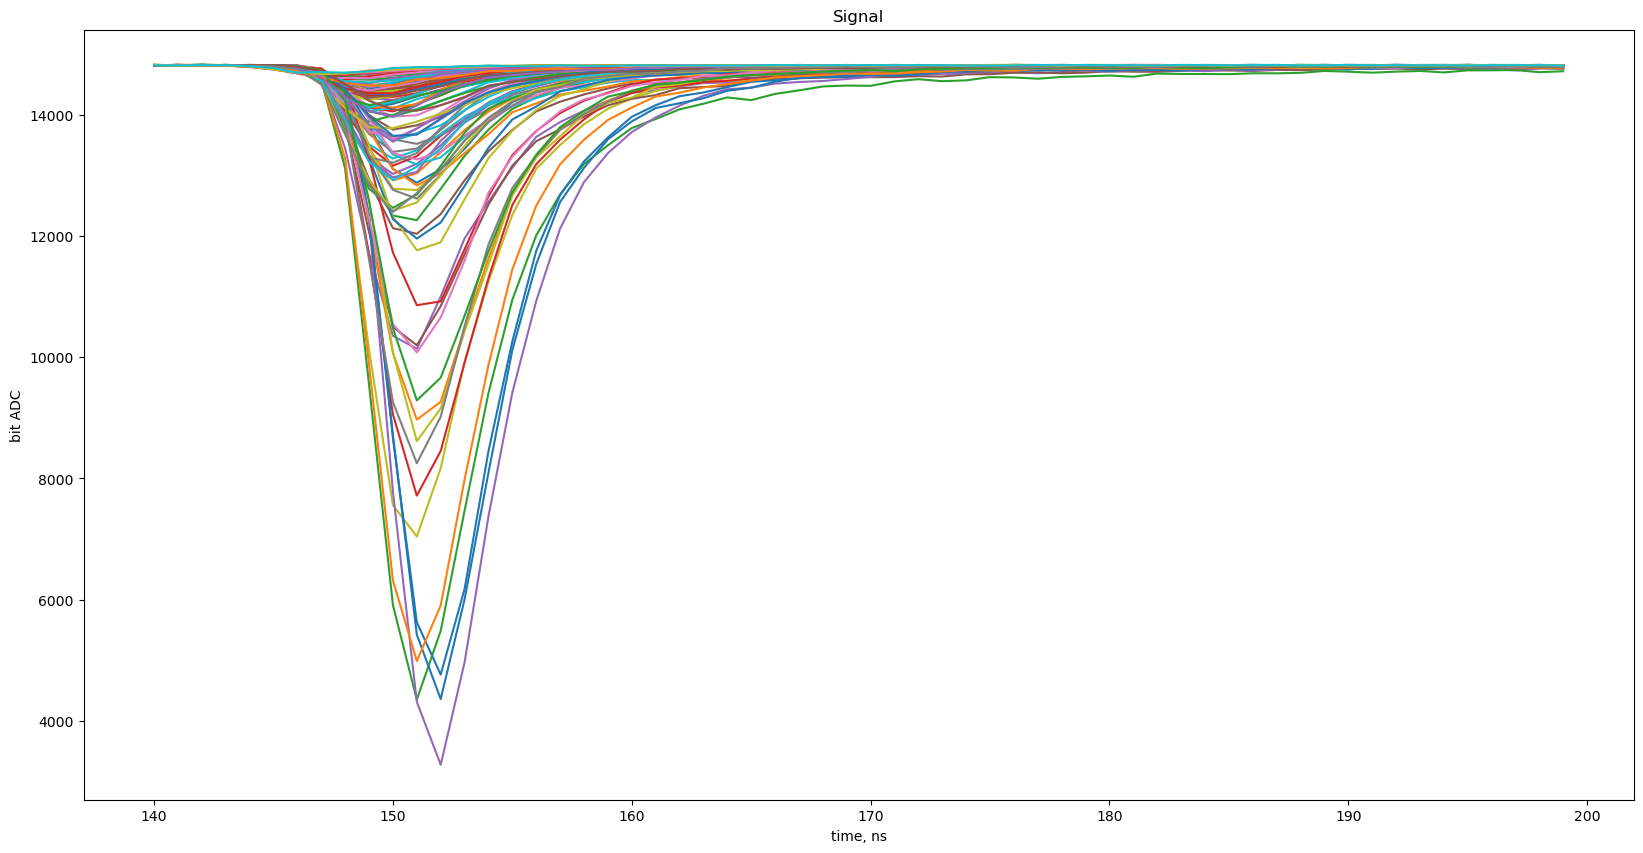

In [4]:
N=range(0,100)
ax = data.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Text(0, 0.5, 'bit ADC')

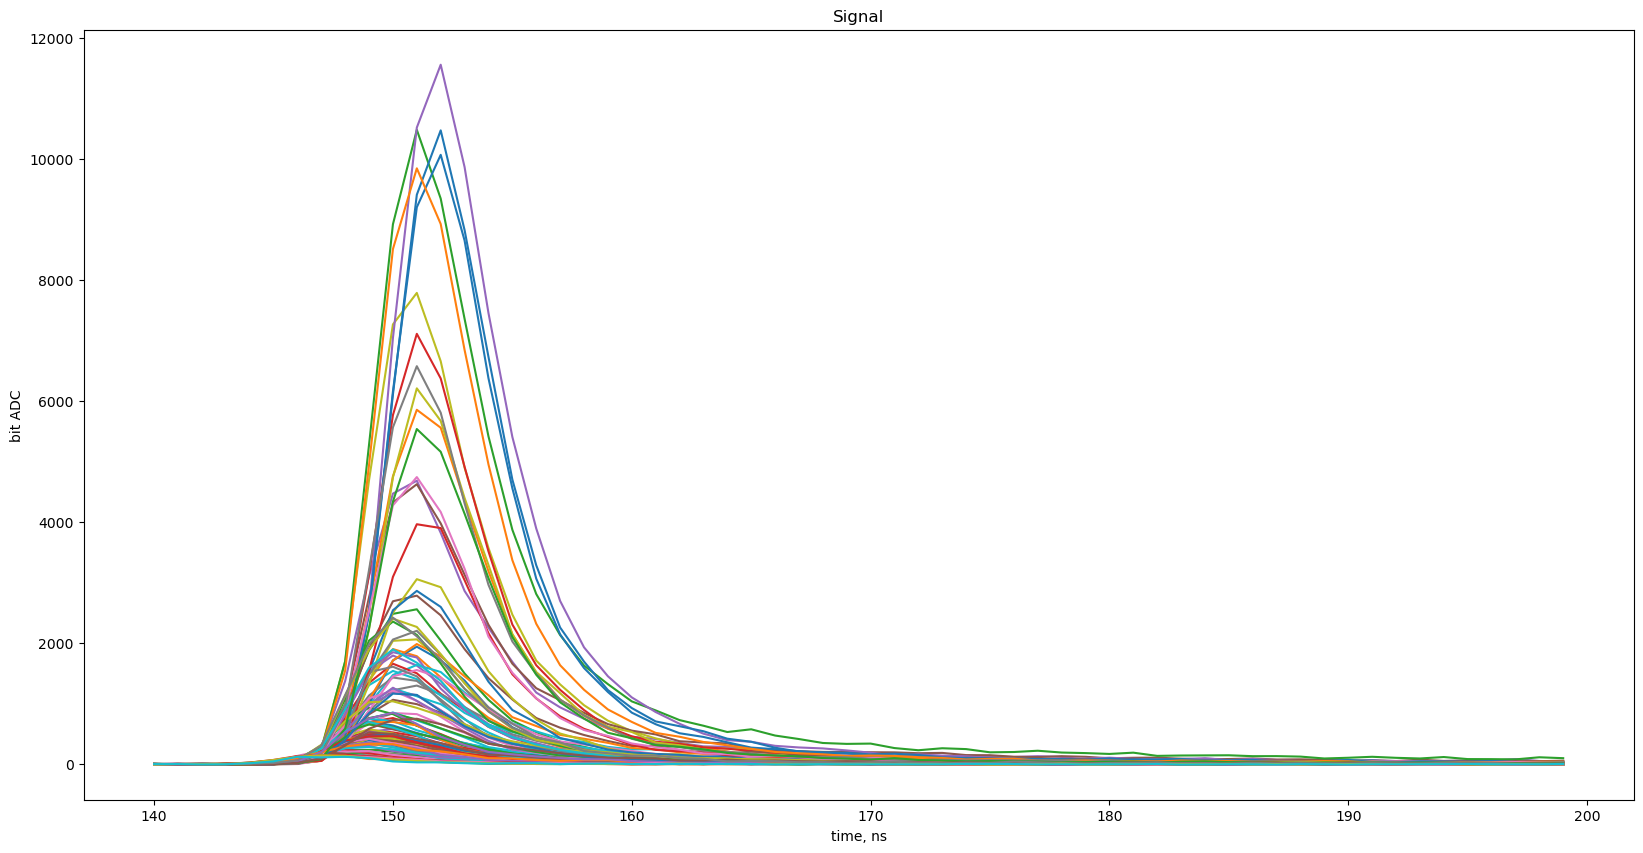

In [5]:
ax = (2**14-data.T[N]-1560)[140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

In [6]:
print("Количество пропущенных значений:", data.isnull().sum().sum())

Количество пропущенных значений: 0


In [8]:
print(data.describe())

                0             1             2             3             4    \
count  23479.000000  23479.000000  23479.000000  23479.000000  23479.000000   
mean   14822.972316  14822.958474  14822.970016  14822.989991  14823.003961   
std        2.805884      2.833516      2.840755      2.852066      2.833412   
min    14812.000000  14812.000000  14812.000000  14811.000000  14812.000000   
25%    14821.000000  14821.000000  14821.000000  14821.000000  14821.000000   
50%    14823.000000  14823.000000  14823.000000  14823.000000  14823.000000   
75%    14824.000000  14824.000000  14825.000000  14825.000000  14825.000000   
max    14834.000000  14835.000000  14834.000000  14835.000000  14834.000000   

                5             6             7             8             9    \
count  23479.000000  23479.000000  23479.000000  23479.000000  23479.000000   
mean   14822.978619  14822.968610  14822.954470  14822.963670  14822.968908   
std        2.836271      2.831241      2.827526    

## Задача


Кластеризовать сигналы на три кластера:

Класс 0 — сигналы, соответствующие первому типу частиц (гамма-кванты или нейтроны),
Класс 1 — сигналы, соответствующие второму типу частиц,
Кластер 2 — сигналы, не поддающиеся однозначной классификации (аномальные, смешанные или выбросы).

## Ход решения

Для решения задачи необходимо определить порог начала сигнала, при превышении которого начинается сигнал, и порог, после которого сигнал заканчивается.

Начало сигнала было определено как первая точка после минимального значения, где значение превышает порог, основанный на разнице между медианой и минимальным значением. Порог для определения окочания сигнала рассчитывается как медиана в диапазоне от 300 до 399 за минусом трех стандартных отклонений этого же диапазона.

Для каждого сигнала находим максимум и инвертируем его: разница между максимумом и каждым значением, плюс 2 (чтобы усилить контраст), в результате получаем инвертированные сигналы. Испрользуем также экспоненциальную подгонку для быстро возрастающих и убывающих данных.

Далее необходимо определить амплитуду - максимальное значение сигнала и площадь под сигналом.

На графиках, визуализирующих сигналы, можно увидеть, что есть также и нетипичные сигналы (где например есть 2 и более пика или пик неправильной формы - не острый, а прямой). Такие сигналы будем считать аномальными и сразу их выделим отдельно. К ним же добавим шумы - все, что было до нулевого порога.

In [14]:
# Подобран параметр step_value=0.3 для того, чтобы определить границу сигнала
# При данном значении шага достигается максимальное значение метрики в дальнейшем
step_value = 0.3
extracted_signals = []
print('Извлечение сигнала началось')


for row in tqdm(data.itertuples()):
    row_values = row[1:]
    min_index = np.argmin(row_values)
    median_val = np.median(row_values[300:400])
    gap_size = median_val - row_values[min_index]

    # определяем начало сигнала
    start_point = 0
    while (row_values[min_index] + step_value * gap_size >= row_values[min_index + start_point]):
        start_point += 1

    # определяем конец сигнала
    end_point = 0
    three_sigma_val = median_val - 3 * np.std(row_values[300:400], ddof=0)
    continue_condition = True

    try:
        while continue_condition:
            end_point += 1
            continue_condition = row_values[min_index + start_point + end_point] <= three_sigma_val
    except IndexError:
        extracted_signals.append(list(row_values[min_index + start_point:]))
    else:
        extracted_signals.append(list(row_values[min_index + start_point:min_index + start_point + end_point]))

print('Извлечение сигнала завершено')

# Инверсия сигналов
inverted_signals = [(np.amax(signal) - np.array(signal) + 2) for signal in extracted_signals]

# Экспоненциальная подгонка
fit_coefficients = []
error_indices = []

for idx, current_signal in tqdm(enumerate(inverted_signals)):
    x_vals = np.arange(1, len(current_signal) + 1)
    y_vals = current_signal
    try:
        initial_params = (1, 1e-6, 1)
        optimized_params, _ = curve_fit(lambda x, a, b, c: a * np.exp(-b * x) + c, x_vals, y_vals, p0=initial_params)
        fit_coefficients.append(optimized_params)
    except RuntimeError:
        error_indices.append(idx)

# Создание датафрейма с коэффициентами и метками кластеров
# Значения вне диапазона считаются особенными (кластер=2) - шумы, аномалии
data_length = data.shape[0]
error_flags = [1 if i in error_indices else 0 for i in range(data_length)]
coeff_list = []
counter = 0

for i in range(data_length):
    if error_flags[i] == 0:
        coeff_list.append(fit_coefficients[counter][1])
        counter += 1
    else:
        coeff_list.append(-1)

result_df = pd.DataFrame()
result_df['coeff'] = coeff_list
result_df['cluster'] = 0
# Классификация по условию: если coeff вне диапазона (0;0.65), то кластер=2
result_df.loc[((0>result_df.coeff) | (result_df.coeff>0.65)), 'cluster'] = 2

Извлечение сигнала началось


23479it [00:04, 5189.86it/s]


Извлечение сигнала завершено


23479it [00:17, 1355.54it/s]


In [16]:
# Подготовка данных по индексам
filtered_indices = np.array([i for i, coeff in enumerate(coeff_list) if 0 < coeff < 0.6]) # признаки с коэффициентами в диапазоне от 0 до 0,6
filtered_coeffs = np.array([coeff for i, coeff in enumerate(coeff_list) if 0 < coeff < 0.6])
filtered_signals = np.array(inverted_signals, dtype=object)[filtered_indices]

max_vals = np.vectorize(max)(filtered_signals)
min_vals = np.vectorize(min)(filtered_signals)
amplitudes = max_vals - min_vals
square = np.vectorize(sum)(filtered_signals)

features_df = pd.DataFrame({
    'Коэффициент': filtered_coeffs,
    'Амплитуда': amplitudes,
    'Площадь под сигналом': square,
    'Сигналы': filtered_signals,
    'Индексы': filtered_indices
})

features_df.head()

,Коэффициент,Амплитуда,Площадь под сигналом,Сигналы,Индексы
0,0.272953,343,1513,"[345, 273, 198, 175, 124, 73, 64, 57, 49, 33, ...",0
1,0.342289,1058,3951,"[1060, 756, 539, 386, 276, 192, 139, 112, 76, ...",1
2,0.360856,1482,5452,"[1484, 1049, 706, 516, 356, 272, 187, 178, 120...",2
3,0.313523,332,1526,"[334, 239, 177, 145, 113, 73, 50, 41, 34, 15, ...",3
4,0.346242,930,3461,"[932, 646, 451, 320, 236, 198, 161, 95, 60, 56...",4


Далее проведем PCA для понижения размерности и посмотрим на графике, как распределились данные.

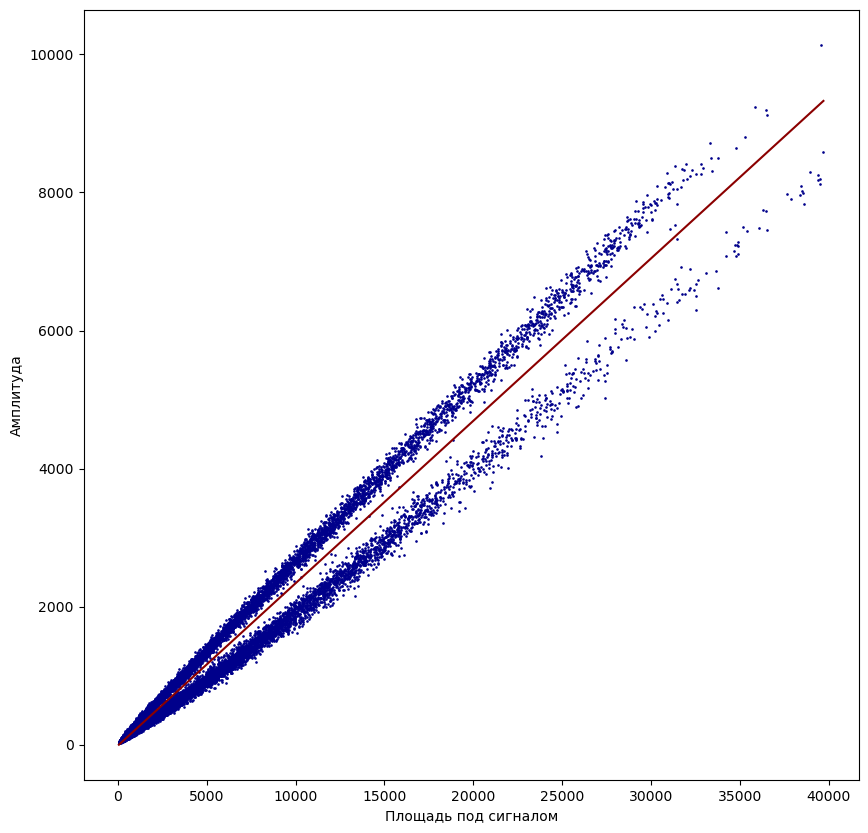

In [17]:
processed_data = np.array([
    [i,
     features_df['Площадь под сигналом'].iloc[i],
     features_df['Амплитуда'].iloc[i],
     features_df['Индексы'].iloc[i]]
    for i in range(len(features_df))
])
plot_data = processed_data[:, 1:3]

# Выполняем PCA
pca_model = PCA(n_components=2)
pca_result = pca_model.fit_transform(plot_data)

W_pca = pca_model.components_
line_slope = -W_pca[1, 0] / W_pca[1, 1]

plt.figure(figsize=(10, 10))
plt.scatter(plot_data[:, 0], plot_data[:, 1], s=0.8, color='darkblue')
x_vals = np.array([min(plot_data[:,0]), max(plot_data[:,0])])
y_vals = (line_slope * x_vals) + pca_model.mean_[1] - line_slope * pca_model.mean_[0]
plt.plot(x_vals, y_vals, color='darkred')
plt.xlabel('Площадь под сигналом')
plt.ylabel('Амплитуда')
plt.show()

# Расчет расстояний до линии
features_df['distance'] = features_df[['Площадь под сигналом', 'Амплитуда']].apply(
    lambda point: abs(line_slope * point[0] - point[1] + pca_model.mean_[1] - line_slope * pca_model.mean_[0]) / np.sqrt(line_slope ** 2 + 1),
    axis=1
)

Мы видим на графике, что линия делит данные на 2 кластера. Далее проведем кластеризацию, сравним три модели - GMM, K-means и DBScan.

## Кластеризация

### Кластеризация Gaussian Mixture Model (GMM)

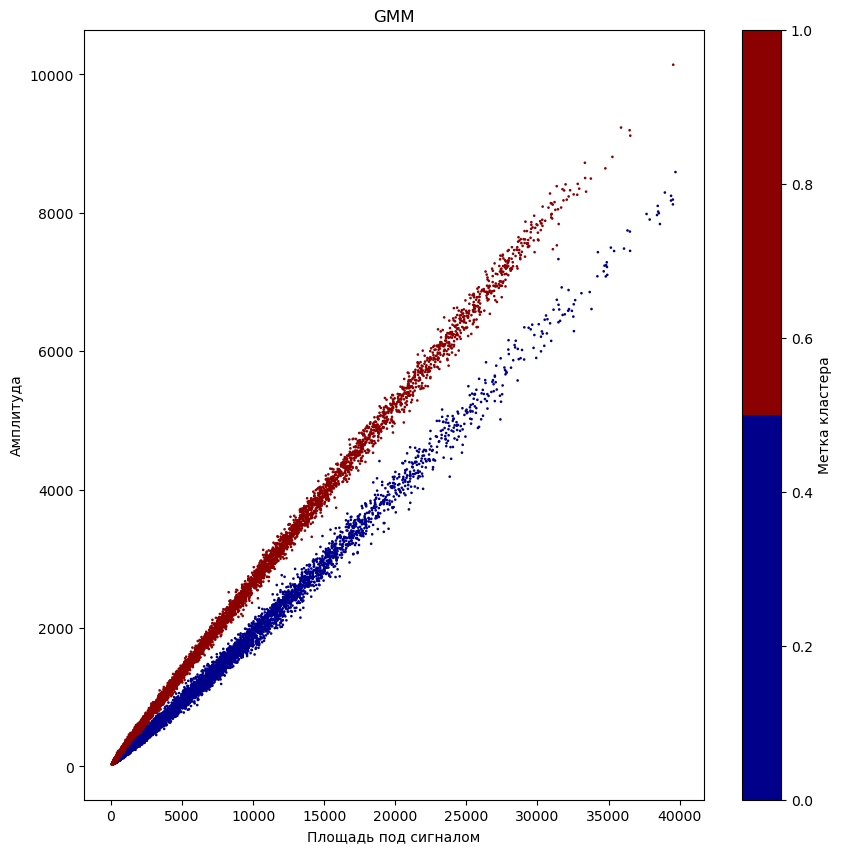

In [18]:
# Кластеризация GMM
clustering_data = features_df.drop(columns=['Коэффициент', 'Сигналы'])
scaled_clustering_data = StandardScaler().fit_transform(clustering_data)
gmm_clusterer = GaussianMixture(n_components=2, random_state=42)
gmm_cluster_labels = gmm_clusterer.fit_predict(scaled_clustering_data)
features_df['cluster_gmm'] = np.where(gmm_cluster_labels == 0, 1, 0)

cmap_custom = ListedColormap(['darkblue', 'darkred'])
plt.figure(figsize=(10, 10))
plt.scatter(
    features_df['Площадь под сигналом'],
    features_df['Амплитуда'],
    c=features_df['cluster_gmm'],
    cmap=cmap_custom,
    s=0.8
)
plt.xlabel('Площадь под сигналом')
plt.ylabel('Амплитуда')
plt.title('GMM')
plt.colorbar(label='Метка кластера')
plt.show()

### Кластеризация K-Means

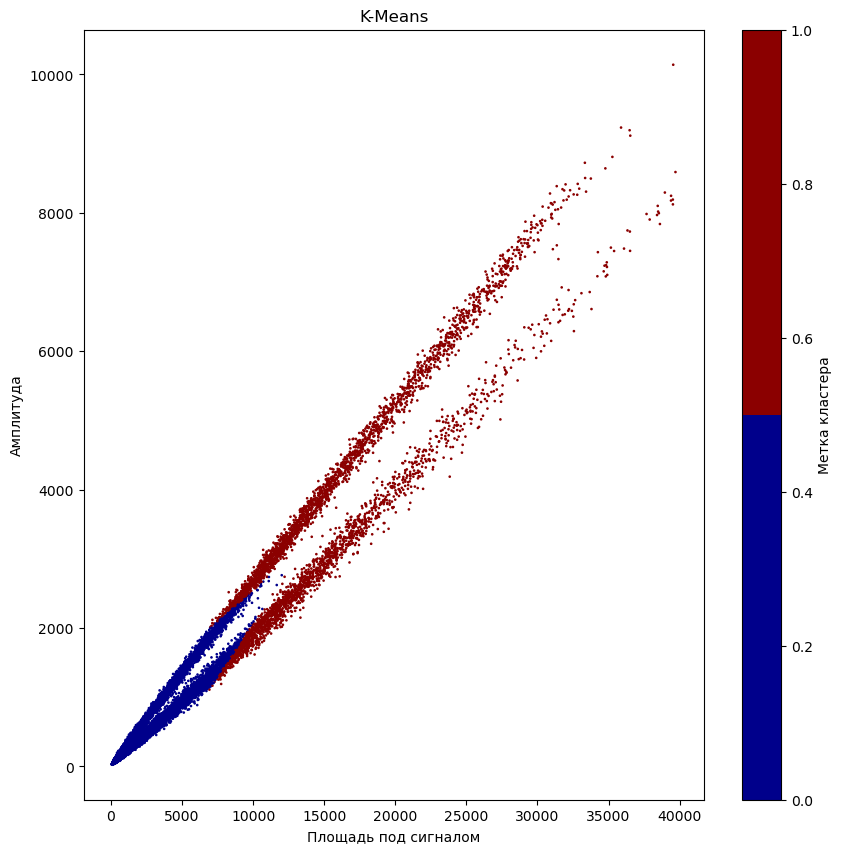

In [19]:
# Кластеризация K-Means
kmeans_clusterer = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans_clusterer.fit_predict(scaled_clustering_data)
features_df['cluster_kmeans'] = kmeans_labels

cmap_custom = ListedColormap(['darkblue', 'darkred'])
plt.figure(figsize=(10, 10))
plt.scatter(
    features_df['Площадь под сигналом'],
    features_df['Амплитуда'],
    c=features_df['cluster_kmeans'],
    cmap=cmap_custom,
    s=0.8
)
plt.xlabel('Площадь под сигналом')
plt.ylabel('Амплитуда')
plt.title('K-Means')
plt.colorbar(label='Метка кластера')
plt.show()

### Кластеризация DBSCAN

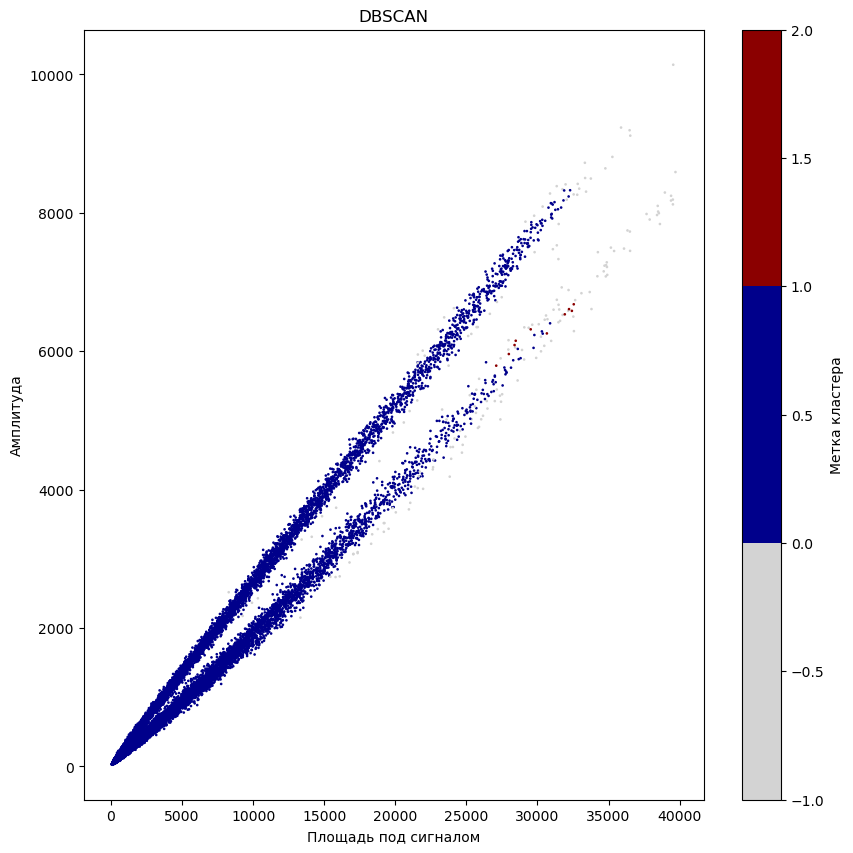

In [20]:
# Кластеризация DBSCAN
dbscan_clusterer = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan_clusterer.fit_predict(scaled_clustering_data)
features_df['cluster_dbscan'] = dbscan_labels
cmap_custom = ListedColormap(['lightgray', 'darkblue', 'darkred'])


plt.figure(figsize=(10, 10))
plt.scatter(
    features_df['Площадь под сигналом'],
    features_df['Амплитуда'],
    c=features_df['cluster_dbscan'],
    cmap=cmap_custom,
    s=0.8
)
plt.xlabel('Площадь под сигналом')
plt.ylabel('Амплитуда')
plt.title('DBSCAN')
plt.colorbar(label='Метка кластера')
plt.show()

### Вывод

На графиках видно, что кластеризацию получилось реализовать с помощью методов K-Means и GMM. DBScan не смог представить адекватную кластеризацию. Лучшую метрику на каггле показал вариант GMM, вероятно, потому, что K-means более чувствителен к шуму, и требуется дополнительная обработка. Но в целом обе модели справились с задачей кластеризации.

## Подготовка ответов

In [21]:
cluster_counts = features_df['cluster_gmm'].value_counts()
print(cluster_counts)
features_df['cluster'] = gmm_clusterer.predict(scaled_clustering_data)
features_df['cluster'].value_counts()
result_df
result_df['index'] = result_df.index
mask = (result_df['cluster'] == 0)
for index in result_df[mask].index:
    num_value = result_df.at[index, 'index']
    if num_value in features_df['Индексы'].values:
        cluster_value = features_df.loc[features_df['Индексы'] == num_value, 'cluster'].values
        if len(cluster_value) > 0:
            result_df.at[index, 'cluster'] = cluster_value[0]
submit_df = result_df.reset_index()[['index', 'cluster']]
submit_df
submit = submit_df.sort_values(by=['index'])

# Поменять кластеры 0 и 1 местами
submit['cluster'] = submit['cluster'].replace({0: 1, 1: 0})

# Сохранить итоговый файл
submit.to_csv('submit_file13.csv', index=False)

cluster_gmm
1    13893
0     9238
Name: count, dtype: int64


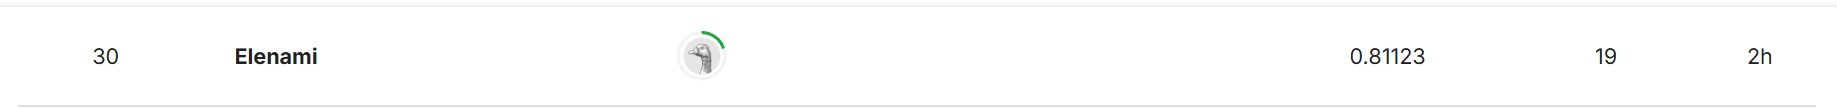